In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import lightgbm as lgb
# import xgboost as xgb
# from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix

bold = '\033[1m'
end = '\033[0m'

In [15]:
train1 = pd.read_csv("train.csv")
train = train1.drop(["Loan_ID"],axis = 1)
print (train.shape)
train['Credit_History'][train.Credit_History == 1.0] = "Yes"
train["Credit_History"][train.Credit_History == 0.0] = "No"
train.head()

(614, 12)


/home/raman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,Yes,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,Yes,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,Yes,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,Yes,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,Yes,Urban,Y


In [16]:
test1 = pd.read_csv("test.csv")
test = test1.drop(["Loan_ID"],axis = 1)
test['Credit_History'][test.Credit_History == 1.0] = "Yes"
test["Credit_History"][test.Credit_History == 0.0] = "No"
print (test.shape)
test.head()

(367, 11)


/home/raman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,Yes,Urban
1,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,Yes,Urban
2,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,Yes,Urban
3,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,Yes,Urban


In [17]:
##E = P×r×(1 + r)n/((1 + r)n - 1)
##average rate of intrest =8.6(for women) 8.65(for men)
##r = 8.6/(12*100) = 0.007166,8.65/(12*100) =0.007208
#E = P*r*(1 + r)**n/((1 + r)**n - 1)
dataset = [train,test]
for i in dataset:
    l = []
    for j in i.Gender.index:
        if i.Gender[j] == "Male":
            r = 8.65/(12*100)
        else:
            r = 8.6/(12*100)
        P = i.LoanAmount[j]*1000
        n = i.Loan_Amount_Term[j]
        E = P*r*(1 + r)**n/((1 + r)**n - 1)
        l.append(E)
    i["EMI"] = l

In [18]:
dataset = [train,test]
for i in dataset:
    i["income"] = i["ApplicantIncome"] + i["CoapplicantIncome"]
#     i["app_income/loan"] = [x[0]/x[1] for x in zip(i["ApplicantIncome"],i["LoanAmount"])]
    i["income/loan"] = [x[0]/x[1] for x in zip(i["income"],i["LoanAmount"])]
    i.drop(["CoapplicantIncome"],axis = 1,inplace = True)
#     i["remain"] = i["income"] - i["EMI"]
#     i["remain2"] = i["ApplicantIncome"] - i["EMI"]

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 13 columns):
Gender              356 non-null object
Married             367 non-null object
Dependents          357 non-null object
Education           367 non-null object
Self_Employed       344 non-null object
ApplicantIncome     367 non-null int64
LoanAmount          362 non-null float64
Loan_Amount_Term    361 non-null float64
Credit_History      338 non-null object
Property_Area       367 non-null object
EMI                 356 non-null float64
income              367 non-null int64
income/loan         362 non-null float64
dtypes: float64(4), int64(2), object(7)
memory usage: 37.4+ KB


In [20]:
train.info()      ## variable identification and type of variable and sie of train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 14 columns):
Gender              601 non-null object
Married             611 non-null object
Dependents          599 non-null object
Education           614 non-null object
Self_Employed       582 non-null object
ApplicantIncome     614 non-null int64
LoanAmount          592 non-null float64
Loan_Amount_Term    600 non-null float64
Credit_History      564 non-null object
Property_Area       614 non-null object
Loan_Status         614 non-null object
EMI                 578 non-null float64
income              614 non-null float64
income/loan         592 non-null float64
dtypes: float64(5), int64(1), object(8)
memory usage: 67.2+ KB


In [21]:
col = train.columns
col

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Property_Area', 'Loan_Status', 'EMI', 'income', 'income/loan'],
      dtype='object')

In [22]:
categorical = train.dtypes[train.dtypes == "object"]
continous = train.dtypes[train.dtypes != "object"]
target = ['Loan_Status']
predictive = list(set(col)-set(target))
print (categorical,continous,target,predictive)

Gender            object
Married           object
Dependents        object
Education         object
Self_Employed     object
Credit_History    object
Property_Area     object
Loan_Status       object
dtype: object ApplicantIncome       int64
LoanAmount          float64
Loan_Amount_Term    float64
EMI                 float64
income              float64
income/loan         float64
dtype: object ['Loan_Status'] ['income', 'Married', 'Gender', 'Credit_History', 'Property_Area', 'EMI', 'Dependents', 'Self_Employed', 'ApplicantIncome', 'Education', 'LoanAmount', 'Loan_Amount_Term', 'income/loan']


## Univariate analysis

In [23]:
for var in categorical.iteritems():
    print (bold + var[0] + end)
    count = train[var[0]].value_counts()
    sum_total = sum([x[1] for x in count.iteritems()])
    for name,val in count.iteritems():
        print ("%.2f%s %s" %((val/sum_total)*100,"%",name),"(%s)" %(val))


Gender
81.36% Male (489)
18.64% Female (112)
Married
65.14% Yes (398)
34.86% No (213)
Dependents
57.60% 0 (345)
17.03% 1 (102)
16.86% 2 (101)
8.51% 3+ (51)
Education
78.18% Graduate (480)
21.82% Not Graduate (134)
Self_Employed
85.91% No (500)
14.09% Yes (82)
Credit_History
84.22% Yes (475)
15.78% No (89)
Property_Area
37.95% Semiurban (233)
32.90% Urban (202)
29.15% Rural (179)
Loan_Status
68.73% Y (422)
31.27% N (192)


From this analysis it become clear that mostly male married graduate who has no child usually doing jobs and have previous credit history too usually comes to take loan from banks.

In [24]:
train.describe()

,ApplicantIncome,LoanAmount,Loan_Amount_Term,EMI,income,income/loan
count,614.000000,592.000000,600.00000,578.000000,614.000000,592.000000
mean,5403.459283,146.412162,342.00000,1208.877399,7024.705081,51.225813
std,6109.041673,85.587325,65.12041,812.681375,6458.663872,37.916644
min,150.000000,9.000000,12.00000,69.841054,1442.000000,12.090196
25%,2877.500000,100.000000,360.00000,788.406609,4166.000000,35.525718
50%,3812.500000,128.000000,360.00000,1013.439878,5416.500000,41.426540
75%,5795.000000,168.000000,360.00000,1372.041681,7521.750000,51.777440
max,81000.000000,700.000000,480.00000,9689.107301,81000.000000,396.366667


## Bivarate Analysis

There are 3 cases:
1. cat-cat ## for this we plot crosstab
2. con-con ## for this we plot scatter plot
3. con-cat ## for this we plot box plot

In [25]:
already_done = []
print (bold,"Analysis of categorical vs categorical variable",end)
print (" ")
for i in categorical.iteritems():
    for j in categorical.iteritems():
        if (i[0] != j[0] and (i[0],j[0]) not in already_done and (j[0],i[0]) not in already_done):
            already_done.append((i[0],j[0]))
            print ("cross-tab of%s %s and %s%s:" %(bold,i[0],j[0],end))
            print(pd.crosstab(train[i[0]],train[j[0]]))
            print (" ")

 Analysis of categorical vs categorical variable 
 
cross-tab of Gender and Married:
Married   No  Yes
Gender           
Female    80   31
Male     130  357
 
cross-tab of Gender and Dependents:
Dependents    0   1   2  3+
Gender                     
Female       80  19   7   3
Male        258  82  92  45
 
cross-tab of Gender and Education:
Education  Graduate  Not Graduate
Gender                           
Female           92            20
Male            376           113
 
cross-tab of Gender and Self_Employed:
Self_Employed   No  Yes
Gender                 
Female          89   15
Male           402   63
 
cross-tab of Gender and Credit_History:
Credit_History  No  Yes
Gender                 
Female          17   84
Male            69  382
 
cross-tab of Gender and Property_Area:
Property_Area  Rural  Semiurban  Urban
Gender                                
Female            24         55     33
Male             151        172    166
 
cross-tab of Gender and Loan_Status:
Loan_Stat

 Analysis of categorical vs continous variable 
 
box-plot between Gender and ApplicantIncome:


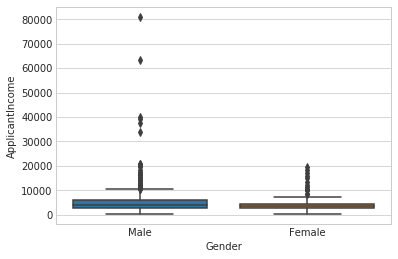

 
box-plot between Gender and LoanAmount:


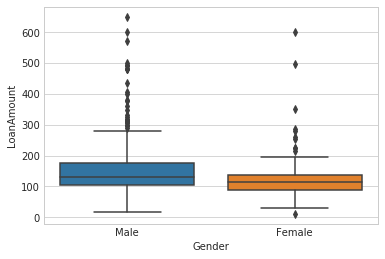

 
box-plot between Gender and Loan_Amount_Term:


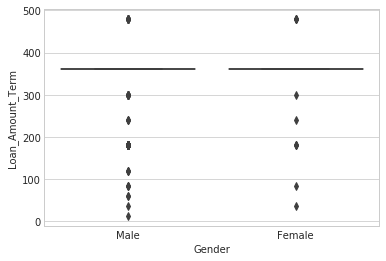

 
box-plot between Gender and EMI:


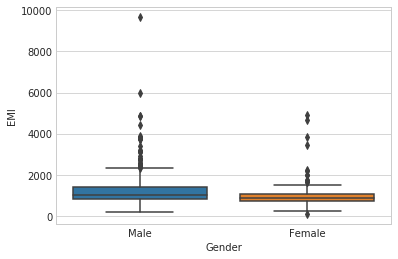

 
box-plot between Gender and income:


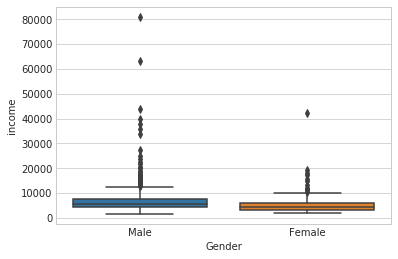

 
box-plot between Gender and income/loan:


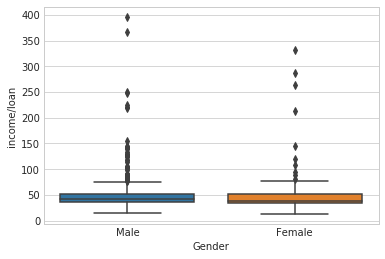

 
box-plot between Married and ApplicantIncome:


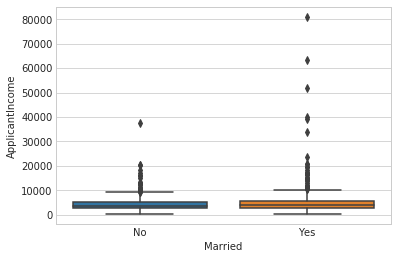

 
box-plot between Married and LoanAmount:


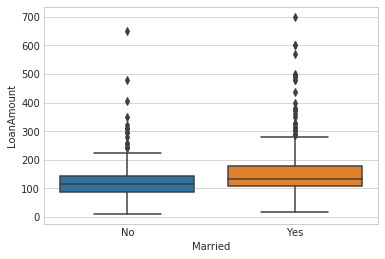

 
box-plot between Married and Loan_Amount_Term:


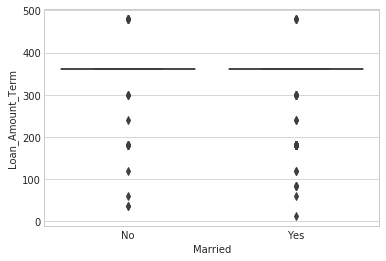

 
box-plot between Married and EMI:


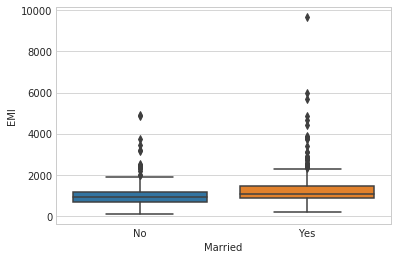

 
box-plot between Married and income:


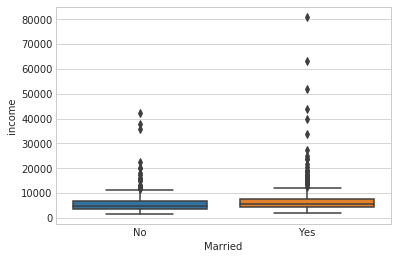

 
box-plot between Married and income/loan:


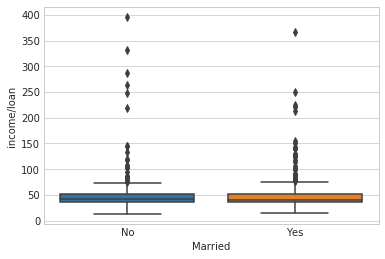

 
box-plot between Dependents and ApplicantIncome:


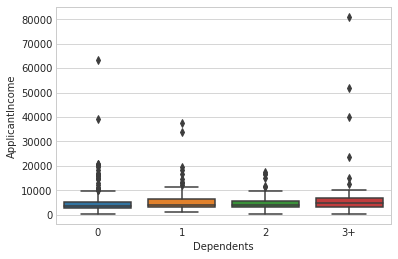

 
box-plot between Dependents and LoanAmount:


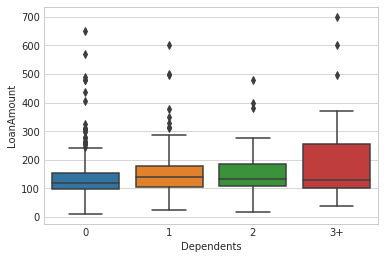

 
box-plot between Dependents and Loan_Amount_Term:


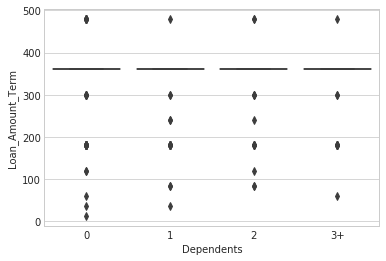

 
box-plot between Dependents and EMI:


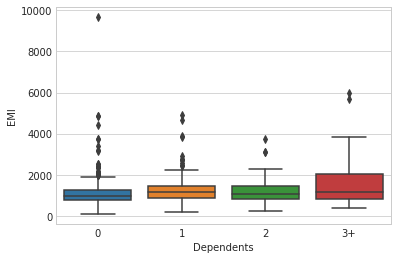

 
box-plot between Dependents and income:


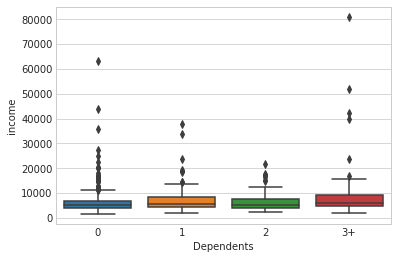

 
box-plot between Dependents and income/loan:


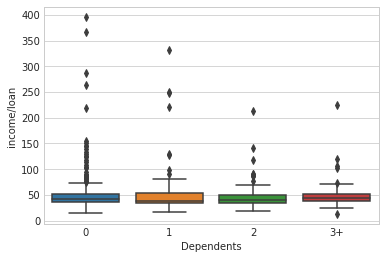

 
box-plot between Education and ApplicantIncome:


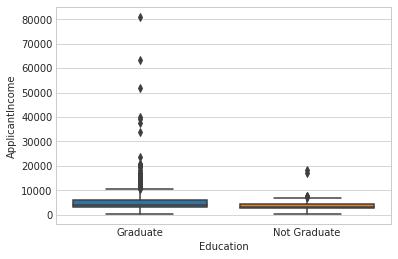

 
box-plot between Education and LoanAmount:


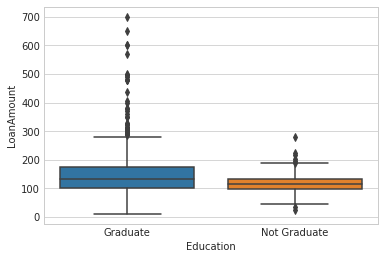

 
box-plot between Education and Loan_Amount_Term:


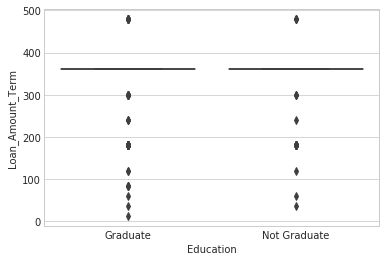

 
box-plot between Education and EMI:


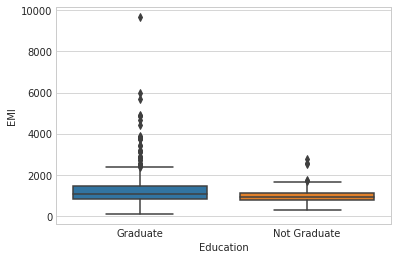

 
box-plot between Education and income:


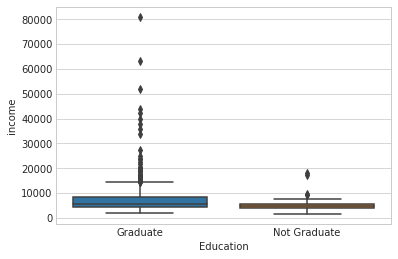

 
box-plot between Education and income/loan:


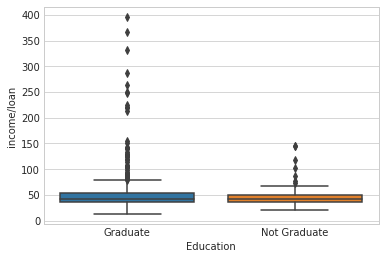

 
box-plot between Self_Employed and ApplicantIncome:


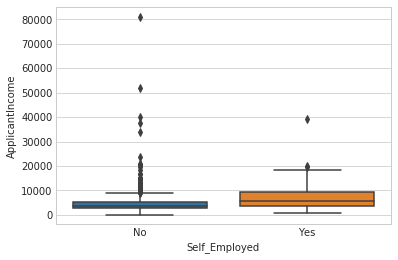

 
box-plot between Self_Employed and LoanAmount:


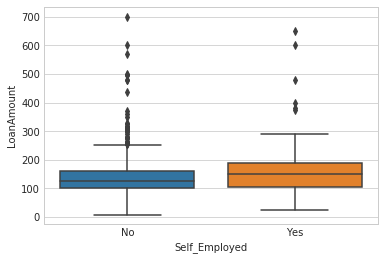

 
box-plot between Self_Employed and Loan_Amount_Term:


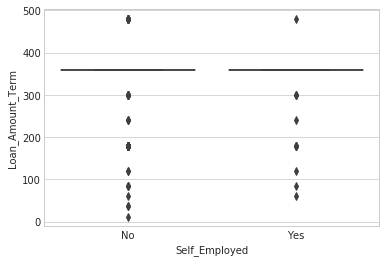

 
box-plot between Self_Employed and EMI:


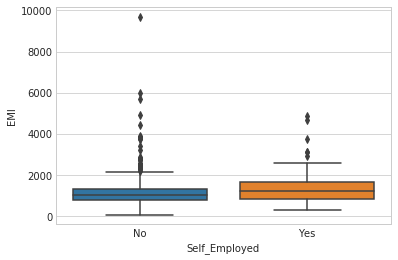

 
box-plot between Self_Employed and income:


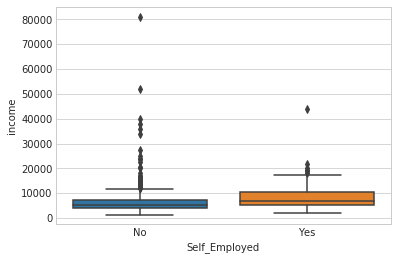

 
box-plot between Self_Employed and income/loan:


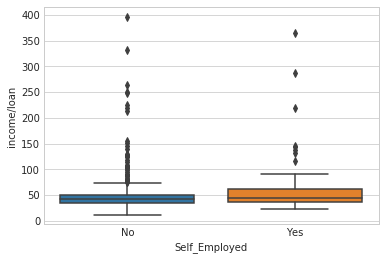

 
box-plot between Credit_History and ApplicantIncome:


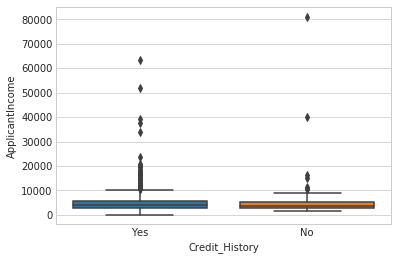

 
box-plot between Credit_History and LoanAmount:


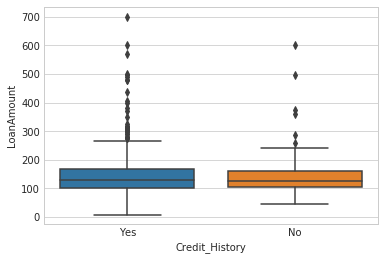

 
box-plot between Credit_History and Loan_Amount_Term:


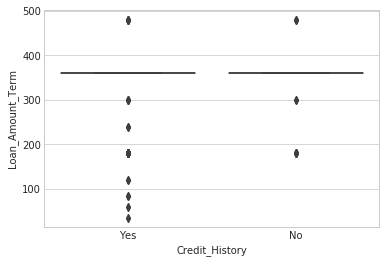

 
box-plot between Credit_History and EMI:


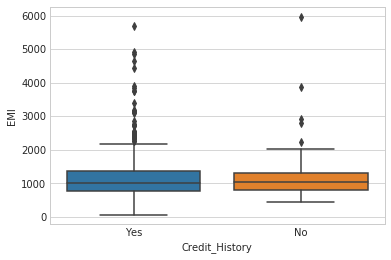

 
box-plot between Credit_History and income:


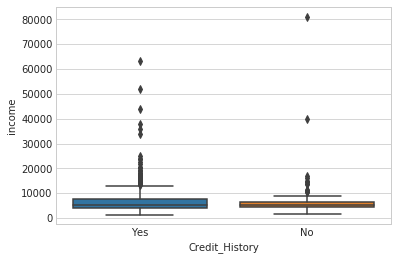

 
box-plot between Credit_History and income/loan:


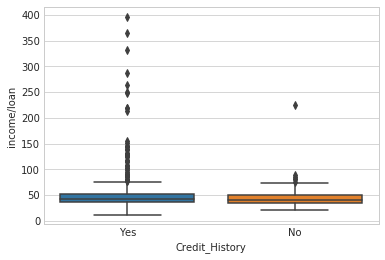

 
box-plot between Property_Area and ApplicantIncome:


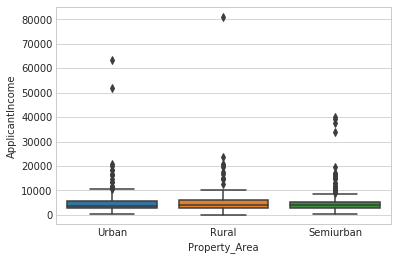

 
box-plot between Property_Area and LoanAmount:


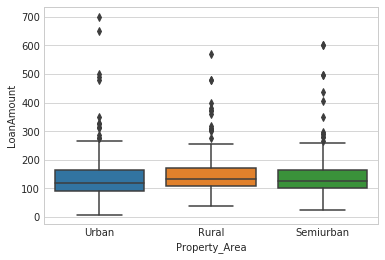

 
box-plot between Property_Area and Loan_Amount_Term:


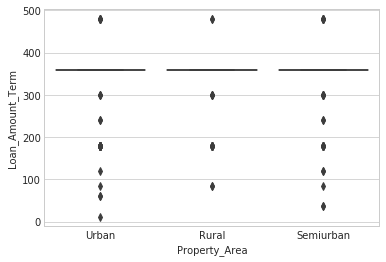

 
box-plot between Property_Area and EMI:


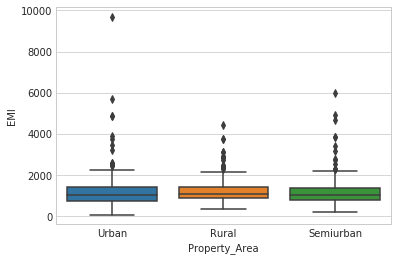

 
box-plot between Property_Area and income:


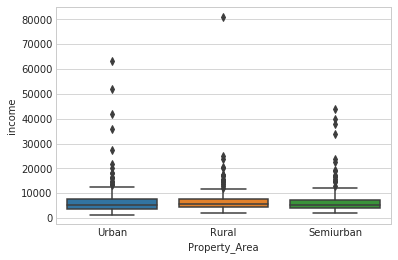

 
box-plot between Property_Area and income/loan:


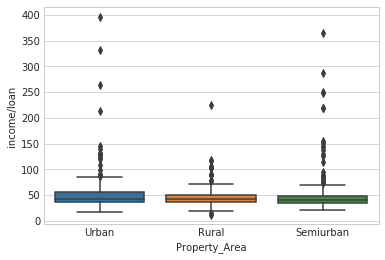

 
box-plot between Loan_Status and ApplicantIncome:


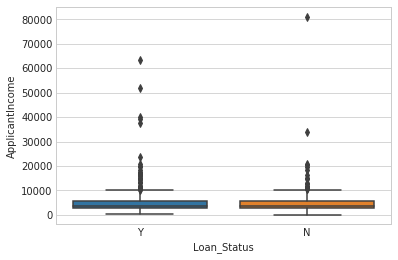

 
box-plot between Loan_Status and LoanAmount:


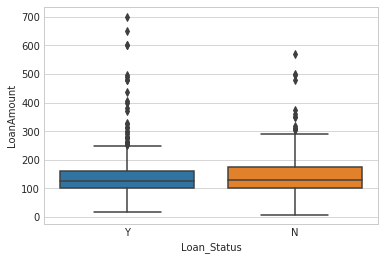

 
box-plot between Loan_Status and Loan_Amount_Term:


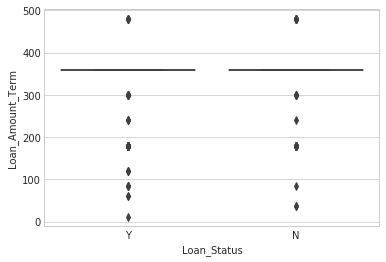

 
box-plot between Loan_Status and EMI:


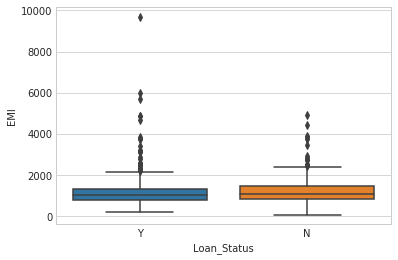

 
box-plot between Loan_Status and income:


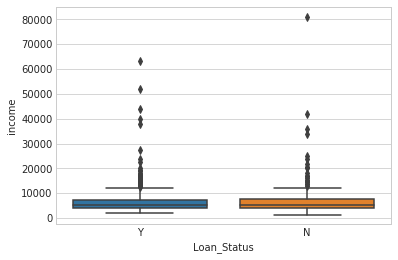

 
box-plot between Loan_Status and income/loan:


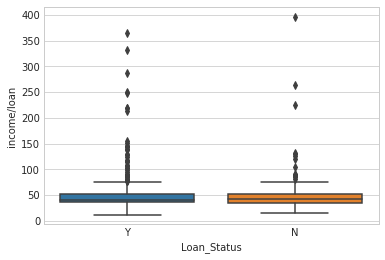

In [26]:
already_done  = []
print (bold,"Analysis of categorical vs continous variable",end)
print (" ")
for i in categorical.iteritems():
    for j in continous.iteritems():
        if (i[0] != j[0] and (i[0],j[0]) not in already_done and (j[0],i[0]) not in already_done):
            already_done.append((i[0],j[0]))
            print ("box-plot between %s%s and %s%s:" %(bold,i[0],j[0],end))
            sns.set_style("whitegrid")
            sns.boxplot(train[i[0]],train[j[0]])
            plt.show()
            print (" ")

the co-relation between ApplicantIncome and LoanAmount: 0.570909038989


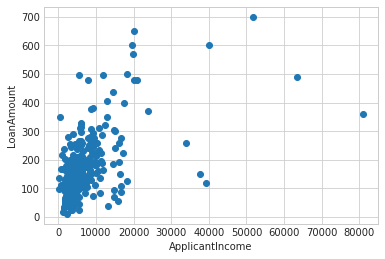

 
the co-relation between ApplicantIncome and Loan_Amount_Term: -0.0453060870626


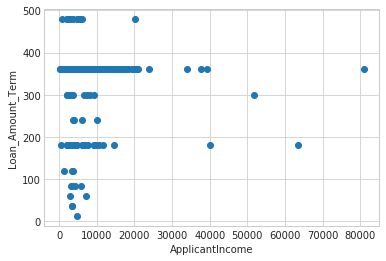

 
the co-relation between ApplicantIncome and EMI: 0.501891251063


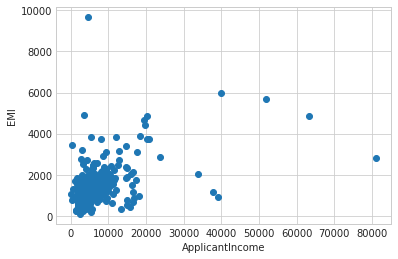

 
the co-relation between ApplicantIncome and income: 0.893037294068


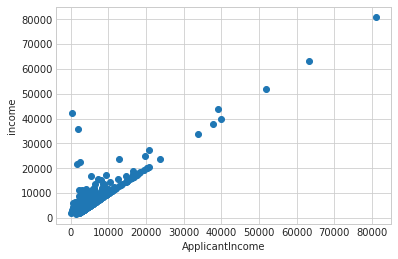

 
the co-relation between ApplicantIncome and income/loan: 0.403510503488


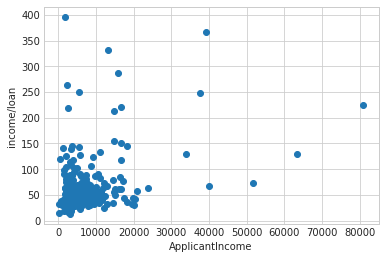

 
the co-relation between LoanAmount and Loan_Amount_Term: 0.039447250916


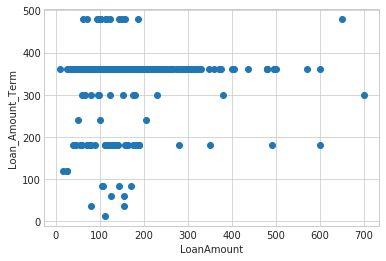

 
the co-relation between LoanAmount and EMI: 0.842191972017


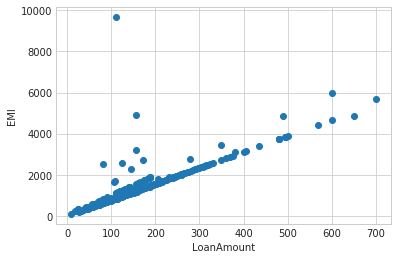

 
the co-relation between LoanAmount and income: 0.624620695998


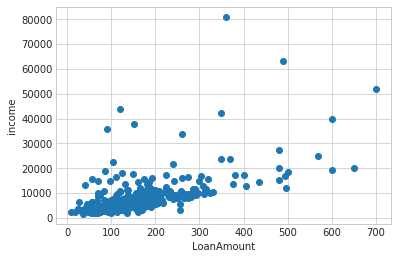

 
the co-relation between LoanAmount and income/loan: -0.139872302024


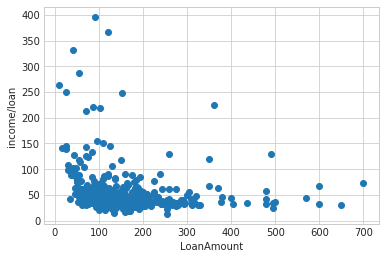

 
the co-relation between Loan_Amount_Term and EMI: -0.265615246464


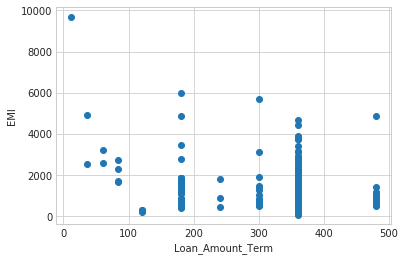

 
the co-relation between Loan_Amount_Term and income: -0.069948409955


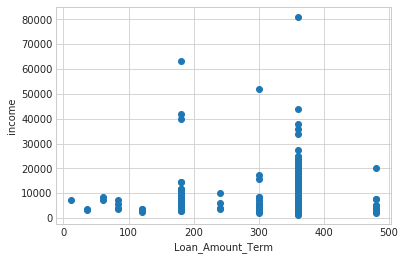

 
the co-relation between Loan_Amount_Term and income/loan: -0.108263084704


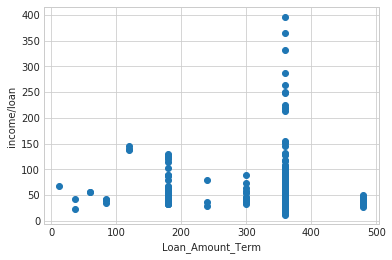

 
the co-relation between EMI and income: 0.556329573453


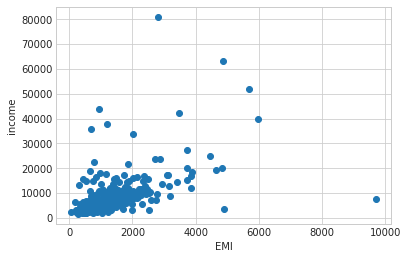

 
the co-relation between EMI and income/loan: -0.102277792858


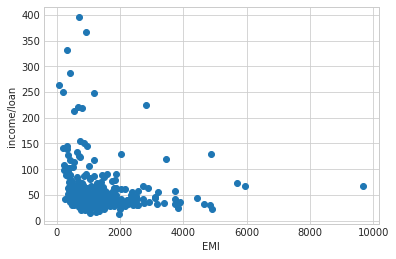

 
the co-relation between income and income/loan: 0.510116330079


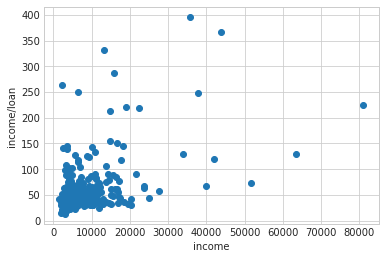

In [27]:
already_done = []
for i in continous.iteritems():
    for j in continous.iteritems():
        if (i[0]!=j[0] and (i[0],j[0]) not in already_done and (j[0],i[0]) not in already_done):
            already_done.append((i[0],j[0]))
            %matplotlib inline
            print ("the co-relation between %s%s and %s: %s%s" %(bold,i[0],j[0],train[i[0]].corr(train[j[0]]),end))
            plt.scatter(train[i[0]],train[j[0]])
            plt.xlabel(i[0])
            plt.ylabel(j[0])
            plt.show()
            print (" ")

## Inputing missing Values

In [13]:
test.Loan_Status = np.nan
alldata = pd.concat([train,test],axis = 0).reset_index(drop = True)
alldata.Dependents[alldata.Dependents == '3+'] = 4
alldata.Dependents = alldata.Dependents.astype('float64')
print (alldata.shape)
alldata.head()

(981, 12)


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_Status,Married,Property_Area,Self_Employed
0,5849,0.0,Yes,0.0,Graduate,Male,NaN,360.0,Y,No,Urban,No
1,4583,1508.0,Yes,1.0,Graduate,Male,128.0,360.0,N,Yes,Rural,No
2,3000,0.0,Yes,0.0,Graduate,Male,66.0,360.0,Y,Yes,Urban,Yes
3,2583,2358.0,Yes,0.0,Not Graduate,Male,120.0,360.0,Y,Yes,Urban,No
4,6000,0.0,Yes,0.0,Graduate,Male,141.0,360.0,Y,No,Urban,No


In [14]:
## Filling the missing values of married by the mode.
alldata.Married[alldata.Married.isnull()] = alldata.Married.unique()[1]

#filling the missing values of gender
alldata.Gender[alldata.Gender.isnull()] = np.random.choice(["Male","Female"],size = sum(alldata.Gender.isnull()),replace  = True)

#filling the missing values of self_employed
alldata.Self_Employed[alldata.Self_Employed.isnull()] =np.random.choice(['Yes','No'],size = sum(alldata.Self_Employed.isnull()))

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
def input_missing_value(df_,col):
    x = list(df_.columns[~df_.isnull().any()])
    x.append(col)
    df = df_[x]
    train = df[df[col].notnull()]
    test = df[df[col].isnull()]
    
    le = LabelEncoder()
    for x in train.columns[train.dtypes == 'object']:
        train[x] = le.fit_transform(train[x])
        test[x][test[x].notnull()]  = le.transform(test[x][test[x].notnull()])

    target = train[col]
    train.drop([col],axis = 1,inplace = True)
    test.drop([col],axis = 1,inplace = True)
    from sklearn.neighbors import KNeighborsClassifier
    cl = KNeighborsClassifier()
    cl.fit(train,target)
    pred = cl.predict(test)
    if(col in df.columns[df.dtypes == 'object']):
        le.fit_transform(df[col][df[col].notnull()])
        pred = le.inverse_transform(pred)
    df_[col][df_[col].isnull()] = pred
    return df_

In [16]:
alldata = input_missing_value(alldata,'Loan_Amount_Term')
alldata= input_missing_value(alldata,'Dependents')
alldata= input_missing_value(alldata,'LoanAmount')
alldata= input_missing_value(alldata,'Credit_History')
alldata.dtypes

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\core\generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

ApplicantIncome        int64
CoapplicantIncome    float64
Credit_History        object
Dependents           float64
Education             object
Gender                object
LoanAmount           float64
Loan_Amount_Term     float64
Loan_Status           object
Married               object
Property_Area         object
Self_Employed         object
dtype: object

In [17]:
alldata.head()

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_Status,Married,Property_Area,Self_Employed
0,5849,0.0,Yes,0.0,Graduate,Male,116.0,360.0,Y,No,Urban,No
1,4583,1508.0,Yes,1.0,Graduate,Male,128.0,360.0,N,Yes,Rural,No
2,3000,0.0,Yes,0.0,Graduate,Male,66.0,360.0,Y,Yes,Urban,Yes
3,2583,2358.0,Yes,0.0,Not Graduate,Male,120.0,360.0,Y,Yes,Urban,No
4,6000,0.0,Yes,0.0,Graduate,Male,141.0,360.0,Y,No,Urban,No


In [18]:
train = alldata[alldata.Loan_Status.notnull()]
target = pd.DataFrame(train.Loan_Status,columns =["Loan_Status"])
target[target == "Y"] = 1
target[target=="N"] = 0
target = target.astype("int")
train.drop(["Loan_Status"],axis = 1,inplace = True)
test = alldata[alldata.Loan_Status.isnull()]
test.drop(["Loan_Status"],axis = 1,inplace = True)
print (train.shape,test.shape)


(614, 11) (367, 11)


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Outlier Detection

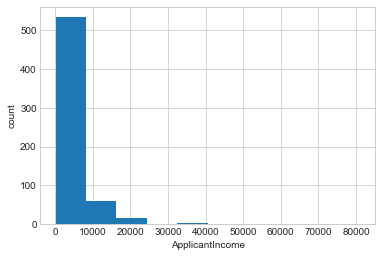

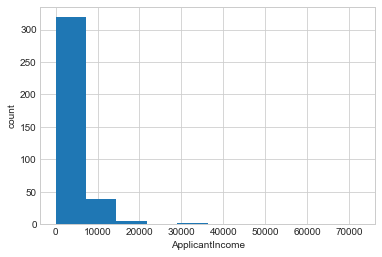

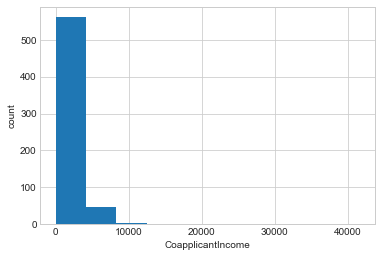

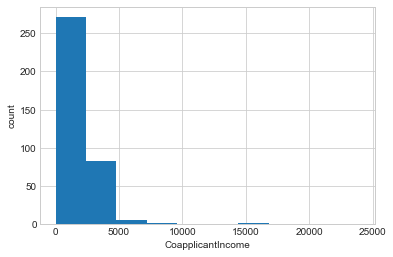

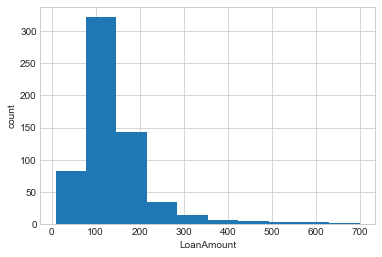

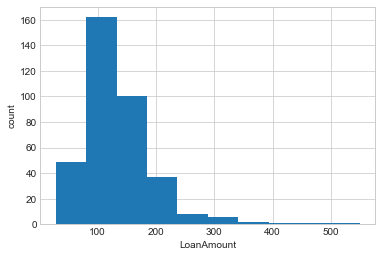

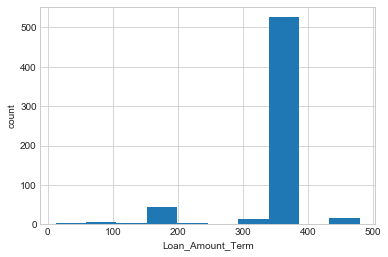

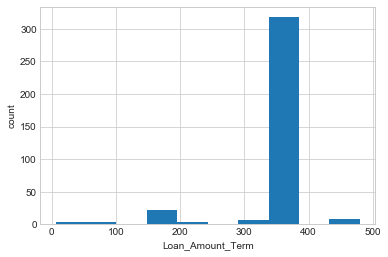

In [19]:
dataframe = [train,test]
for col in continous.iteritems():
    for df in dataframe:
        plt.hist(df[col[0]])
        plt.xlabel(col[0])
        plt.ylabel("count")
        plt.show()

here we see:
- since applicant and coapplicant income both are left skewed so we will use log or sqrt or cbrt.
- since loan amount term is ryt skewed so we take square or cube of its value.
here i dont knw but if a data is ryy skewed we will take log ,cbrt,sqrt.

## Feature Engineering

In [20]:
##feature creation->creating dummy encoders(for categories<=6) or label encoders for categorical data and other features based on previous knowledge
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [21]:
train["total_income"] = (train["ApplicantIncome"] + train["CoapplicantIncome"])/train["LoanAmount"]## income_by_loan
train["ApplicantIncome"] = np.cbrt(train["ApplicantIncome"])
train["CoapplicantIncome"] = np.cbrt(train["CoapplicantIncome"])
train["total_income"] = np.cbrt(train["total_income"])
train["Loan_Amount_Term"] = np.square(train["Loan_Amount_Term"])

test["total_income"] = (test["ApplicantIncome"] + test["CoapplicantIncome"])/test["LoanAmount"]## income_by_loan
test["ApplicantIncome"] = np.cbrt(test["ApplicantIncome"])
test["CoapplicantIncome"] = np.cbrt(test["CoapplicantIncome"])
test["total_income"] = np.cbrt(test["total_income"])
test["Loan_Amount_Term"] = np.square(test["Loan_Amount_Term"])

In [22]:
##feature transformation->standardising data and binning (if neccessary)
for col in continous.iteritems():
    for df in dataframe:
        df[col[0]] = (df[col[0]] - np.mean(df[col[0]]))/np.std(df[col[0]])

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Training model and tunnning parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain.values, ytrain.values.ravel())
    print ("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [ ]:
def do_classify(clf , Xtrain, Xtest, ytrain,parameters =False):
    if (parameters !=False):
        clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    training_precision = precision_score(clf.predict(Xtrain), ytrain)
    training_recall = recall_score(clf.predict(Xtrain), ytrain)
    training_F1 = f1_score(clf.predict(Xtrain), ytrain)
    return (clf.predict(Xtrain),clf.predict(Xtest),training_accuracy,training_precision,training_recall,training_F1)

In [ ]:
lr = LogisticRegression()
nv = GaussianNB()
svm = SVC(cache_size = 5000)
rf = RandomForestClassifier(random_state = 0,n_jobs = -1,oob_score = True,max_features='sqrt')
gbc = GradientBoostingClassifier(random_state = 0,max_features='sqrt')
models = { lr: {"Logistic Regression":{"C":[0.0000001,0.000001,0.00001,0.0001,0.001],"max_iter":[0.1,1,10,100]}},svm:{"SVM":{"C":[0.01,0.1,1,10],"gamma":[0.01,0.1,1,10],"kernel":["rbf"]}} , rf: {"Random Forest":{"min_samples_split":range(2,25),"n_estimators":[10,100,200,300]}}, gbc: {"Gradient Boosting Classifier":{"learning_rate":[0.5,1,2],"min_samples_split":range(2,25),"n_estimators":[10,100,200,300]}} }
evaluation = pd.DataFrame(columns=['Model','Accuracy','Precision','Recall','F1 Score'])

In [ ]:
def to_labels(x):
    if x == 1:  # cutoff - you can change it and see if accuracy improves or plot AUC curve. 
        return "Y"
    return "N"

# result = pd.DataFrame({"Loan_ID":(test1.Loan_ID),"Loan_Status":(pred)}).reset_index(drop = True)
# result['Loan_Status'] = result['Loan_Status'].map(lambda x: to_labels(x))
# result[["Loan_ID","Loan_Status"]].to_csv("loan_prediction_K_NN.csv",index = False)

In [ ]:
true = target
i = 1
predi = []
for key,value in models.items():
    [pred,pred1,acc,prec,rec,f1] = do_classify(key,train,test,target,value.values())
    
    result = pd.DataFrame({"Loan_ID":(test1.Loan_ID),"Loan_Status":(pred1)}).reset_index(drop = True)
    result['Loan_Status'] = result['Loan_Status'].map(lambda x: to_labels(x))
    result[["Loan_ID","Loan_Status"]].to_csv("loan_prediction_%s.csv" %(value.keys()),index = False)
    
    evaluation.loc[i] =[value.keys(),acc,prec,rec,f1] 
    i = i+1
    print (confusion_matrix(true,pred))
evaluation

In [ ]:
d_train2 = lgb.Dataset(train, label = target)

In [ ]:
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_error',
    'learning_rate': 0.04, 
    'max_depth': 5, 
    'num_leaves': 21, 
    'feature_fraction': 0.3, 
    'bagging_fraction': 0.8, 
    'bagging_freq': 5}

In [ ]:
lgb_cv2 = lgb.cv(params, d_train2, num_boost_round=1000, nfold= 5, shuffle=True, stratified=True, verbose_eval=20, early_stopping_rounds=100)

In [ ]:
nround2 = lgb_cv2['binary_error-mean'].index(np.min(lgb_cv2['binary_error-mean']))